Sign Language Detection using Action detection utilizing tensorflow, opencv, mediapipe, and sklearn

In [22]:
#importing dependencies
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time 
import mediapipe as mp #used to extract keypoints from face, hands, arms

In [23]:
mp_holistic = mp.solutions.holistic #holistic model, used make our detections
mp_drawing = mp.solutions.drawing_utils #drawing utilities, used to draw the detections

In [24]:

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #color conversion from BGR to RGB
    image.flags.writeable = False                  #image not writeable
    results = model.process(image)                 #make prediction using model holistic
    image.flags.writeable = True                   #image is writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #color conversion from RGB to BGR
    return image, results

In [25]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # draw right hand connections

In [26]:
#drawing landmarks with more styling
def draw_styled_landmarks(images, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness =1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness =2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) # draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(200,11,50), thickness =2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(300,256,21), thickness=2, circle_radius=2)) # draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(10,210,90), thickness =2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(200,56,221), thickness=2, circle_radius=2)) # draw right hand connection


In [7]:
#Media pipe test to see how can use the libraries to gather the data

cap = cv2.VideoCapture(0)#accessing webcam
#set mediapipe model
with mp_holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): #while webcam is open

        ret, frame = cap.read() #looping through all the frames and reading

        #Make Detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        #draw landmarks in real time
        draw_styled_landmarks(image, results)

        cv2.imshow('Webcam Feed', image) #show to screen
        #can use q to quit 
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release() #release webcam
    cv2.destroyAllWindows() # close down the frames


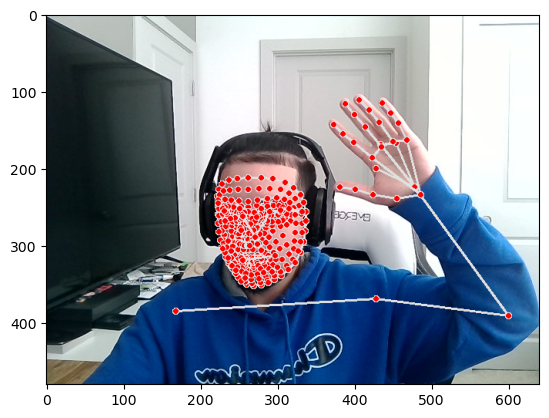

In [8]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Extract keypoint values   

In [27]:
#concatenating the landmarks into a numpy array and adding 0s for empty data
#getting all different landmarks and flattening them into one dimension array
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)

In [28]:
#extracting all key points and concatenating them together for training
def extract_keypoints(results):   
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    leftHand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) # need to put zeros for landmarks that weren't recorded.
    rightHand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3) # need to put zeros for landmarks that weren't recorded.
    face =  np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) # need to put zeros for landmarks that weren't recorded
    return np.concatenate([pose, face, leftHand, rightHand])

In [29]:
#path for exporting data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

#actions that we want to try and detect in sign language
actions = np.array(['hello', 'thanks', 'iloveyou'])

#thirty videos worth of data
no_sequences = 30

#videos are 30 frames in lenth
sequence_length = 30


In [ ]:
#hello folder

#thanks folder

#I love You folder

In [30]:
#creating folder for each action of data
#for each action, hello, thanks, I love you
for action in actions:
    #for each video
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))# make folder per
        except:
            pass

In [31]:
#collecting data. 
cap = cv2.VideoCapture(0)#accessing webcam
#set mediapipe model
with mp_holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
    
   #go through all of the different actions
    for action in actions:  
        #loop through the sequence/videos
        for sequence in range(no_sequences):
            #Loop through video length, 30 frames of key points
            for frame_num in range(sequence_length):
                
                ret, frame = cap.read() #looping through all the frames and reading

                #Make Detections
                image, results = mediapipe_detection(frame, holistic)
                #print(results)

                #draw landmarks in real time
                draw_styled_landmarks(image, results)
                
                #Applying logic to give time between each action
                
                if frame_num == 0: # if at frame 0 then we wait for 2 seconds
                    #adding messages to see whats going on
                    cv2.putText(image, 'STARTING COLLECTION', (120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action,sequence),
                                (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    
                    cv2.imshow('Webcam Feed', image) #show to screen
                    #making it wait 2 seconds
                    cv2.waitKey(1500)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action,sequence),
                                (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.imshow('Webcam Feed', image) #show to screen
                    
                #extract key points data and storing in files
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

               
                
                #can use q to quit 
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release() #release webcam
    cv2.destroyAllWindows() # close down the frames

In [32]:
#preprocessing data, creating labels
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

label_map = {label:num for num, label in enumerate(actions)}#actions that we declared above


In [33]:
sequences, labels = [], [] #x, y

for action in actions:
    for sequence in range(no_sequences):#30 videos
        window = []#all the frames in that video
        for frame_num in range(sequence_length): # loop through frames
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window) # 90 different videos of 30 frames each
        labels.append(label_map[action])

In [34]:
X = np.array(sequences)
y = to_categorical(labels).astype(int) #converted to binary flag to represent each action

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) #splitting train and test data



Building and Training the LSTM Neural Network
- less data required for accurate model
- faster to train because less dense network
- faster detection because its simpler

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir) #allows to monitor neural network training

#building LSTM Neural network layers
model = Sequential()

model.add(LSTM(64, return_sequences= True, activation = 'relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences= True, activation = 'relu'))
model.add(LSTM(64, return_sequences= False, activation = 'relu'))#not returning sequence because next is dense layer
#fully connected layers
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(actions.shape[0], activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics= ['categorical_accuracy'])
#cetegorical_crossentropy needed for multiclass classification

model.fit(X_train, y_train, epochs=250, callbacks=[tb_callback])



Epoch 1/250


3/3 [==============================] - 4s 24ms/step - loss: 1.1550 - categorical_accuracy: 0.2706
Epoch 2/250
3/3 [==============================] - 0s 21ms/step - loss: 8.5593 - categorical_accuracy: 0.3882
Epoch 3/250
3/3 [==============================] - 0s 22ms/step - loss: 3.4805 - categorical_accuracy: 0.5529
Epoch 4/250
3/3 [==============================] - 0s 21ms/step - loss: 3.7636 - categorical_accuracy: 0.1176
Epoch 5/250
3/3 [==============================] - 0s 21ms/step - loss: 1.7023 - categorical_accuracy: 0.3647
Epoch 6/250
3/3 [==============================] - 0s 21ms/step - loss: 1.3455 - categorical_accuracy: 0.4706
Epoch 7/250
3/3 [==============================] - 0s 22ms/step - loss: 1.6367 - categorical_accuracy: 0.5412
Epoch 8/250
3/3 [==============================] - 0s 22ms/step - loss: 2.2155 - categorical_accuracy: 0.3882
Epoch 9/250
3/3 [==============================] - 0s 21ms/step - loss: 1.4949 - categorical_accuracy: 0.4824
Epoch 10

3/3 [==============================] - 0s 21ms/step - loss: 0.2876 - categorical_accuracy: 0.9176
Epoch 71/250
3/3 [==============================] - 0s 21ms/step - loss: 0.2305 - categorical_accuracy: 0.9529
Epoch 72/250
3/3 [==============================] - 0s 21ms/step - loss: 0.2670 - categorical_accuracy: 0.9294
Epoch 73/250
3/3 [==============================] - 0s 20ms/step - loss: 0.1790 - categorical_accuracy: 0.9647
Epoch 74/250
3/3 [==============================] - 0s 21ms/step - loss: 0.2142 - categorical_accuracy: 0.9412
Epoch 75/250
3/3 [==============================] - 0s 21ms/step - loss: 0.1932 - categorical_accuracy: 0.9529
Epoch 76/250
3/3 [==============================] - 0s 22ms/step - loss: 0.1329 - categorical_accuracy: 0.9412
Epoch 77/250
3/3 [==============================] - 0s 21ms/step - loss: 0.0809 - categorical_accuracy: 0.9529
Epoch 78/250
3/3 [==============================] - 0s 21ms/step - loss: 0.0705 - categorical_accuracy: 0.9882
Epoch 79/250
3

3/3 [==============================] - 0s 21ms/step - loss: 3.6738e-04 - categorical_accuracy: 1.0000
Epoch 143/250
3/3 [==============================] - 0s 20ms/step - loss: 3.5283e-04 - categorical_accuracy: 1.0000
Epoch 144/250
3/3 [==============================] - 0s 22ms/step - loss: 3.5176e-04 - categorical_accuracy: 1.0000
Epoch 145/250
3/3 [==============================] - 0s 22ms/step - loss: 3.4738e-04 - categorical_accuracy: 1.0000
Epoch 146/250
3/3 [==============================] - 0s 21ms/step - loss: 3.3340e-04 - categorical_accuracy: 1.0000
Epoch 147/250
3/3 [==============================] - 0s 21ms/step - loss: 3.2047e-04 - categorical_accuracy: 1.0000
Epoch 148/250
3/3 [==============================] - 0s 21ms/step - loss: 3.1465e-04 - categorical_accuracy: 1.0000
Epoch 149/250
3/3 [==============================] - 0s 21ms/step - loss: 3.0625e-04 - categorical_accuracy: 1.0000
Epoch 150/250
3/3 [==============================] - 0s 21ms/step - loss: 2.9116e-04 -

3/3 [==============================] - 0s 21ms/step - loss: 1.0022e-04 - categorical_accuracy: 1.0000
Epoch 213/250
3/3 [==============================] - 0s 21ms/step - loss: 9.9320e-05 - categorical_accuracy: 1.0000
Epoch 214/250
3/3 [==============================] - 0s 21ms/step - loss: 9.8749e-05 - categorical_accuracy: 1.0000
Epoch 215/250
3/3 [==============================] - 0s 21ms/step - loss: 9.7257e-05 - categorical_accuracy: 1.0000
Epoch 216/250
3/3 [==============================] - 0s 21ms/step - loss: 9.5870e-05 - categorical_accuracy: 1.0000
Epoch 217/250
3/3 [==============================] - 0s 21ms/step - loss: 9.4303e-05 - categorical_accuracy: 1.0000
Epoch 218/250
3/3 [==============================] - 0s 22ms/step - loss: 9.2922e-05 - categorical_accuracy: 1.0000
Epoch 219/250
3/3 [==============================] - 0s 22ms/step - loss: 9.2168e-05 - categorical_accuracy: 1.0000
Epoch 220/250
3/3 [==============================] - 0s 21ms/step - loss: 9.1168e-05 -

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 59667

In [37]:
#Make prediction
res = model.predict(X_test)
actions[np.argmax(res[4])]


1/1 [==============================] - 0s 380ms/step


'hello'

In [38]:
#validating test with singular result
actions[np.argmax(y_test[4])]

'hello'

In [40]:
model.save('model.h5')
model.save("model")
#del model
#model.load_weights('model.h5')
#new_model = keras.models.load_model("model.h5")

C:\Users\zaroo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [41]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [42]:
#conversion from one-hot encoded representation to a categorical label such as 0,1,2
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat)

1/1 [==============================] - 0s 16ms/step


array([[[2, 0],
        [0, 3]],

       [[4, 0],
        [0, 1]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [43]:
accuracy_score(ytrue, yhat)

1.0

Testing in Real Time

In [44]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
#use to show realtime prob of being one of the sign language actions
def prob_vids(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                    (255, 255, 255),
                   2, cv2.LINE_AA)
    return output_frame

In [48]:
sequence = []
sentence = [] #concat history of detection
threshold = 0.6 #confidence metric 

cap = cv2.VideoCapture(0)#accessing webcam
#set mediapipe model
with mp_holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): #while webcam is open

        ret, frame = cap.read() #looping through all the frames and reading

        #Make Detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        #draw landmarks in real time
        draw_styled_landmarks(image, results)
        
        #real time prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:] #grab our last 30 frames of prediction
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
        #show visualization of logic
        if res[np.argmax(res)] > threshold: #if result above threshold
            if len(sentence) > 0: # check if words in sentence array
                if actions[np.argmax(res)] != sentence[-1]:#make sure predicted word not same as last
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
                    
        if len(sentence) > 5:
            sentence = sentence[-5:]
        #visualize probability of each action
        
        image = prob_vids(res, actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, 
                   cv2.LINE_AA)#rendering our sentence


        
        cv2.imshow('Webcam Feed', image) #show to screen
        #can use q to quit 
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release() #release webcam
    cv2.destroyAllWindows() # close down the frames

1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 16ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 16ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [===================

1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 14ms/step
hello
1/1 [==============================] - 0s 14ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 14ms/step
hello
1/1 [==============================] - 0s 14m

1/1 [==============================] - 0s 16ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 14ms/step
hello
1/1 [==============================] - 0s 14ms/step
hello
1/1 [==============================] - 0s 14ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 14ms/step
hello
1/1 [==============================] - 0s 14ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [

1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 14ms/step
iloveyou
1/1 [===================

1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 16ms/step
thanks
1/1 [==============================] - 0s 16ms/step
thanks
1/1 [==============================] - 0s 16ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 16ms/step
thanks
1/1 [==============================] - 0s 16ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 16ms/step
thanks
1/1 [==============================] - 0s 16ms/step
than

1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 16ms/step
hello
1/1 [==============================] - 0s 16ms/step
hello
1/1 [==============================] - 0s 15ms/step
hello
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 16ms/step
iloveyou
1/1 [==============================] - 0s 16ms/step
iloveyou
1/1 [==============================] - 0s 16ms/step
iloveyou
1/1 [==============================] - 0s 16ms/step
iloveyou
1/1 [==============================] - 0s 18ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 15ms/step
iloveyou
1/1 [==============================] - 0s 16ms/step
iloveyou
1/1 [==============================] - 0s 16ms/step
iloveyou
1/1 [==============================] - 0s 16ms/step
iloveyou
1/1 [==============================] - 0s 17ms/step
iloveyou
1/1 [==============================]